<a href="https://colab.research.google.com/github/NataliaOsiecka/diel/blob/master/dielectric_delta_H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Case1

parameters for Havrilak-Negami functions:

deltaH=60kJ/mol or 80 kJ/mol

delta epsilon = 0.25

alfa = 0.01

beta = 0.99

A = 5

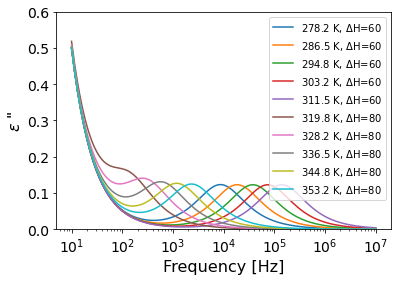

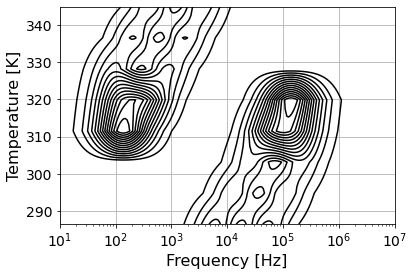

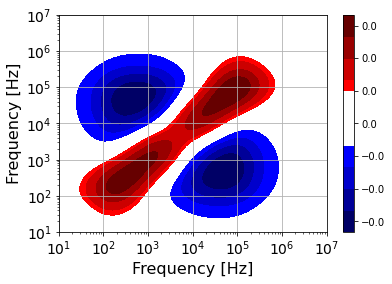

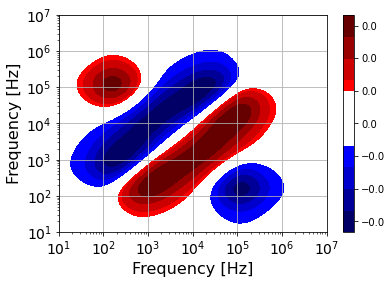

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker 

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

def hnFunction(x, delta, alfa, beta, tau, A):
    #calculating loss part of permetivity
    fi=np.arctan((2*np.pi*x*tau)**(1-alfa)*np.cos(np.pi*alfa/2)/(1+(2*np.pi*x*tau)**(1-alfa)*np.sin(np.pi*alfa/2)))
    eh=delta*np.sin(beta*fi)/(1+2*(2*np.pi*x*tau)**(1-alfa)*np.sin(np.pi*alfa/2)+(2*np.pi*x*tau)**(2-2*alfa))**(beta/2)
    #calculating conductivity
    conductivity = A/x
    e = eh + conductivity
    return e

#tau_0 zmienna niezależna od temperatury, delta_H podawana w kJ, T w C 
def generateTau(delta_H, T):
    tau_0 = 1E-16
    R = 8.3144621 #J/Kmol
    #T = np.linspace(T_min, T_max, num=10) + 273.15
    delta_H = delta_H*1000
    tau = tau_0*np.exp(delta_H/(R*T))
    return tau

def calculate_moving_window_analysis(spectra, temperature):
    moving_window = np.zeros((spectra.shape[1], spectra.shape[0]-2))
    mw_temperature = np.zeros((moving_window.shape[1]))
    for it in range(spectra.shape[0]):
        if it == 0:
            pass
        elif it == spectra.shape[0] - 1:
            pass
        else:
            window = spectra[it-1:it+2]
            mw_temperature[it-1] = np.sum(temperature[it-1:it+2])/3
            syn = calculate_synchronous_spectra(window)
            for i in range(spectra.shape[1]):
                moving_window[i, it-1] = syn[i,i]
    return moving_window, mw_temperature
    
def calculate_synchronous_spectra(spectra):
    dynamic_spectrum = calculate_dynamic_spectra(spectra)
    synchronous = (1/spectra.shape[0])*np.dot(np.transpose(dynamic_spectrum), dynamic_spectrum)
    return synchronous

def calculate_asynchronous_spectra(spectra):
    dynamic_spectrum = calculate_dynamic_spectra(spectra)
    hilbert_matrix = calculate_hilbert_matrix(spectra.shape[0])
    asynchronous = (1/spectra.shape[0])*np.dot(np.dot(np.transpose(dynamic_spectrum),hilbert_matrix), dynamic_spectrum)
    return asynchronous

def calculate_hilbert_matrix(number_of_spectra):
    hil = np.zeros((number_of_spectra, number_of_spectra))
    for i in range(1, number_of_spectra):
        for j in range(i):
            hil[i,j] = 1/(np.pi*(j-i))
            hil[j,i] = -hil[i,j]
    return hil
    
def calculate_dynamic_spectra(spectra):
    matrix = spectra.sum(axis=0).reshape(spectra.shape[1],1)
    dynamic_spectrum = spectra - np.transpose((1/spectra.shape[0])*matrix*np.ones(spectra.shape[0]))
    return dynamic_spectrum

def contourplot(wavenumber, spectra):
    levels = []
    colors = []
    X, Y = np.meshgrid(wavenumber, wavenumber)
    plt.figure()
#usually positive peaks are red and negative peaks are blue on syn and asyn spectra
    if np.min(spectra)<0:
        syn_min = np.min(spectra)
        syn_max = np.max(spectra)
        list1 = [syn_min * i/10 for i in range(1,11)]
        levels = list1[::-1] + [syn_max * i/10 for i in range(11)]
        #colors = ['#000066','#000066','#000099','#000099','#0000cc','#0000cc',\
        #'#0000ff','#0000ff','#66ccff','w','w','#ff6633','#ff0000','#ff0000','#cc0000',\
        #'#cc0000','#990000','#990000','#660000','#660000']
        colors = ['#000066','#000066','#000099','#000099','#0000cc','#0000cc',\
        '#0000ff','#0000ff','w','w','w','w','w','#ff0000','#cc0000',\
        '#cc0000','#990000','#990000','#660000','#660000']
    else:
        syn_max = np.max(spectra)
        levels = [syn_max * i/20 for i in range(21)]
        colors = ['w','w','#000080','#000080','#00008b','#00008b',\
        '#0000cd','#0000cd','#0000ff','#191970','#191970','#ff6633','#ff0000','#ff0000','#cc0000',\
        '#cc0000','#990000','#990000','#660000','#660000']

    syn_contourf = plt.contourf(X,Y,spectra, levels, colors=colors)
    plt.colorbar(syn_contourf, format=OOMFormatter(-4, mathText=False))
    plt.xlabel(r'Frequency [Hz]', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.xscale('log')
    #plt.xlim(3100,700)
    plt.ylabel(r'Frequency [Hz]', fontsize = 16)
    plt.yticks(fontsize = 14)
    plt.yscale('log')
    #plt.ylim(3100,700)
    plt.grid()
    plt.show()
    
y1 = []
deltaH = [60,60,60,60,60,80,80,80,80,80]
temperature = np.linspace(5, 80, num=10) + 273.15
tau =[]
for item in range(10):
    tau1=generateTau(deltaH[item], temperature[item])
    tau.append(tau1)
#tau = generateTau(deltaH, temperature) 
x = np.logspace(1, 7, num=200,base=10.0)
for item in tau:
    spectrum = hnFunction(x, 0.25, 0.01, 0.99, item,5)
    y1.append(spectrum)

for item in y1:
    plt.semilogx(x,item)
plt.xlabel('Frequency [Hz]', fontsize = 16)
plt.xticks(fontsize=14)
plt.ylabel(r'$\epsilon$ "', fontsize = 16)
plt.yticks(fontsize=14)
lg=[]
for item in range(10):
    temp = str(round(temperature[item],1)) + r" K, $\Delta$"+"H="+str(round(deltaH[item],1))
    lg.append(temp)
plt.legend(lg)
plt.ylim(0,0.6)
plt.show()

spectra = np.array(y1)

mw, mwtemp = calculate_moving_window_analysis(spectra, temperature)
X, Y = np.meshgrid(x, mwtemp)
plt.figure()
mw_max = np.max(mw)
levels = [mw_max * i/15 for i in range(16)]
plt.contour(X, Y, np.transpose(mw),levels, colors='black')
plt.xlabel(r'Frequency [Hz]', fontsize = 16)
plt.xscale('log')
plt.xticks(fontsize = 14)
plt.ylabel(r'Temperature [K]', fontsize = 16)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

syn = calculate_synchronous_spectra(spectra)
contourplot(x, syn)

asyn = calculate_asynchronous_spectra(spectra)
contourplot(x,asyn)

Case2

parameters for Havrilak-Negami functions:

deltaH=60kJ/mol or 80 kJ/mol or 60kJ/mol

delta epsilon = 0.25

alfa = 0.01

beta = 0.99

A = 5

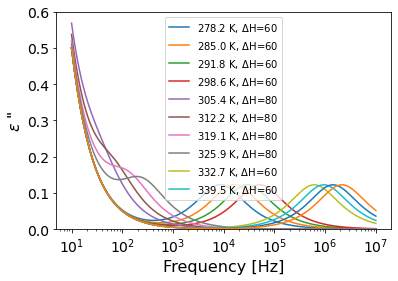

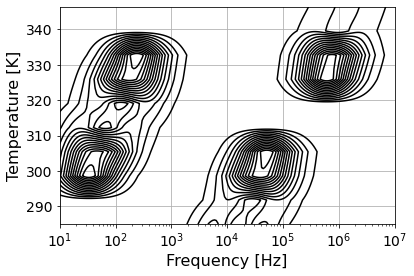

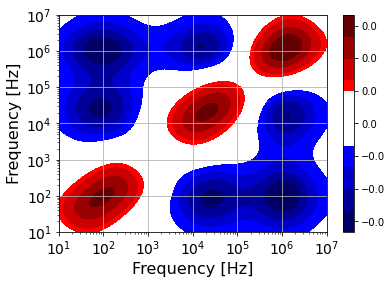

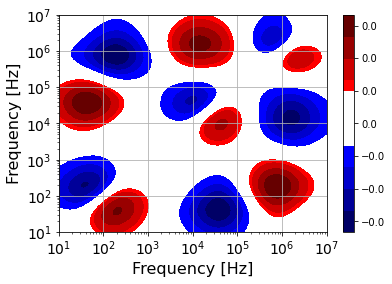

In [2]:
y1 = []
deltaH = [60,60,60,60,80,80,80,80,60,60, 60,60]
temperature = np.linspace(5, 80, num=12) + 273.15
tau =[]
for item in range(12):
    tau1=generateTau(deltaH[item], temperature[item])
    tau.append(tau1)
#tau = generateTau(deltaH, temperature) 
x = np.logspace(1, 7, num=200,base=10.0)
for item in tau:
    spectrum = hnFunction(x, 0.25, 0.01, 0.99, item,5)
    y1.append(spectrum)

for item in y1:
    plt.semilogx(x,item)
plt.xlabel('Frequency [Hz]', fontsize = 16)
plt.xticks(fontsize=14)
plt.ylabel(r'$\epsilon$ "', fontsize = 16)
plt.yticks(fontsize=14)
lg=[]
for item in range(10):
    temp = str(round(temperature[item],1)) + r" K, $\Delta$"+"H="+str(round(deltaH[item],1))
    lg.append(temp)
plt.legend(lg)
plt.ylim(0,0.6)
plt.show()

spectra = np.array(y1)

mw, mwtemp = calculate_moving_window_analysis(spectra, temperature)
X, Y = np.meshgrid(x, mwtemp)
plt.figure()
mw_max = np.max(mw)
levels = [mw_max * i/15 for i in range(16)]
plt.contour(X, Y, np.transpose(mw),levels, colors='black')
plt.xlabel(r'Frequency [Hz]', fontsize = 16)
plt.xscale('log')
plt.xticks(fontsize = 14)
plt.ylabel(r'Temperature [K]', fontsize = 16)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

syn = calculate_synchronous_spectra(spectra)
contourplot(x, syn)

asyn = calculate_asynchronous_spectra(spectra)
contourplot(x,asyn)